# Imports

In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import os

from tqdm import tqdm

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    Activation,
    Add,
    AveragePooling1D,
    BatchNormalization,
    Concatenate,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    Input,
    Layer,
    MaxPooling1D,
    Multiply,
    Reshape
)

# Prerequisites

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/include/tuning_utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/models.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/sca_utils.py /content/
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


In [ ]:
from tuning_utils import CleanMemoryTuner, model_builder_synthetic_se_cnn, vgg_cbam_synthetic_builder
from models import cbam_block, vgg_cnn_cbam
from sca_utils import SBOX, run_rank_trials, plot_mean_rank

In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import os

class SyntheticDataLoader():

    def __init__(self, file_path):
        self.file_path = file_path

    def data_generator(self, window_index=0):
        """
        A generator that yields traces, labels, and metadata (plaintext, key)
        one by one from an HDF5 file.
        """
        with h5py.File(self.file_path, 'r') as hf:
            traces = hf['windows']
            labels = hf['labels']
            plaintexts = hf['metadata/plaintexts']
            keys = hf['metadata/key']
            num_samples = traces.shape[0]

            is_key_fixed = (keys.ndim == 1 and keys.shape[0] != num_samples)
            if is_key_fixed:
                fixed_key_value = keys[:]

            for i in range(num_samples):
                trace = traces[i, window_index, :].astype('float32')
                trace = np.expand_dims(trace, axis=-1)
                label = labels[i].astype('int32')
                pt = plaintexts[i]

                if is_key_fixed:
                    key = fixed_key_value
                else:
                    key = keys[i]

                yield trace, label, pt, key

    def create_dataset(self, window_index=0, batch_size=64, val_split=0.2):
        """
        Creates and splits a tf.data.Dataset for training and validation.
        """
        with h5py.File(self.file_path, 'r') as hf:
            num_samples = hf['windows'].shape[0]
            input_dim = hf['windows'].shape[2]

            pt_dset = hf['metadata/plaintexts']
            pt_shape = (pt_dset.shape[1],) if pt_dset.ndim > 1 else ()

            key_dset = hf['metadata/key']
            # A key element is a vector if the dataset is 2D OR if it's a fixed key (1D but not length num_samples).
            is_key_element_vector = key_dset.ndim > 1 or (key_dset.ndim == 1 and key_dset.shape[0] != num_samples)
            key_shape = (key_dset.shape[-1],) if is_key_element_vector else ()

        dataset = tf.data.Dataset.from_generator(
            lambda: self.data_generator(window_index),
            output_signature=(
                tf.TensorSpec(shape=(input_dim, 1), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=pt_shape, dtype=tf.uint8),
                tf.TensorSpec(shape=key_shape, dtype=tf.uint8)
            )
        )

        val_size = int(num_samples * val_split)
        train_size = num_samples - val_size

        if train_size > 0:
            dataset = dataset.shuffle(buffer_size=min(train_size, 10000))

        ds_full_train = dataset.take(train_size)
        ds_full_val = dataset.skip(train_size)

        ds_train = ds_full_train.map(lambda trace, label, pt, key: (trace, label))

        ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        ds_full_val_batched = ds_full_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        print(f"Dataset created from '{os.path.basename(self.file_path)}':")
        print(f"  - Total samples: {num_samples}")
        print(f"  - Training samples: {train_size}")
        print(f"  - Validation samples: {val_size}")

        return ds_train, ds_full_val_batched, input_dim, train_size, val_size

In [ ]:
class HdfToTfrAdapter():
  def _bytes_feature(self, value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

  def _int64_feature(self, value):
      """Returns an int64_list from a bool / enum / int / uint."""
      return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

  def serialize_example(self, trace, label, plaintext, key_byte):
      """
      Creates a tf.train.Example message ready to be written to a file.
      (MODIFIED to use .tobytes() for stability)
      """
      feature = {
          'trace': self._bytes_feature(trace.tobytes()),
          'label': self._int64_feature(label),
          'plaintext': self._int64_feature(plaintext),
          'key_byte': self._int64_feature(key_byte),
      }
      example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
      return example_proto.SerializeToString()

  def convert_h5_to_tfrecord(self, h5_path, tfrecord_path, window_index=0):
      """
      Converts a single HDF5 file to the TFRecord format, including metadata.
      This version handles cases where metadata might be a scalar value.
      """
      print(f"Starting conversion: {h5_path} -> {tfrecord_path}")

      with h5py.File(h5_path, 'r') as hf:
          # Load all necessary datasets
          traces = hf['windows']
          labels = hf['labels']
          plaintexts_dset = hf['metadata/plaintexts']
          keys_dset = hf['metadata/key']
          num_samples = traces.shape[0]

          # Check if metadata datasets are scalar (single value) or arrays
          is_plaintext_scalar = plaintexts_dset.ndim == 0
          is_key_scalar = keys_dset.ndim == 0

          # If a dataset is scalar, read its single value once.
          plaintext_val = plaintexts_dset[()] if is_plaintext_scalar else None
          key_val = keys_dset[()] if is_key_scalar else None

          with tf.io.TFRecordWriter(tfrecord_path) as writer:
              for i in tqdm(range(num_samples), desc=f"Converting {os.path.basename(h5_path)}"):
                  # Extract the specific window and label
                  trace_data = traces[i, window_index, :].astype('float32')
                  label_data = labels[i].astype('int32')

                  # Get the metadata value: use the single scalar value or slice the array
                  plaintext_data = plaintext_val if is_plaintext_scalar else plaintexts_dset[i]
                  key_byte_data = key_val if is_key_scalar else keys_dset[i]

                  # Serialize and write the complete record to the file
                  example = self.serialize_example(trace_data, label_data, int(plaintext_data), int(key_byte_data))
                  writer.write(example)

      print(f"Conversion complete for {tfrecord_path}")

  def convert_bytes(self, bytes_to_convert, output_dir, window_to_use=0):
    os.makedirs(output_dir, exist_ok=True)

    for target_byte in bytes_to_convert:
        h5_file = os.path.join(SYNTHETIC_PROFILING_BASE_DIR, f'byte_{target_byte}.h5')
        tfrecord_file = os.path.join(output_dir, f'byte_{target_byte}.tfrecord')

        if not os.path.exists(h5_file):
            print(f"Dummy H5 file for byte {target_byte} not found. Creating it.")
            with h5py.File(h5_file, 'w') as f:
                f.create_dataset('windows', data=np.random.rand(50000, 5, 701).astype(np.float32))
                f.create_dataset('labels', data=np.random.randint(0, 256, size=50000).astype(np.int32))
                f.create_dataset('metadata/plaintexts', data=np.random.randint(0, 256, size=50000).astype(np.uint8))
                f.create_dataset('metadata/key', data=np.random.randint(0, 256, size=50000).astype(np.uint8))

        self.convert_h5_to_tfrecord(h5_file, tfrecord_file, window_to_use)

In [ ]:
class TfrDataLoader():
    def serialize_example(self, trace, label, plaintext, key_byte):
      """
      Creates a tf.train.Example message ready to be written to a file.
      """
      feature = {
          'trace': _bytes_feature(trace.tobytes()),
          'label': _int64_feature(label),
          'plaintext': _int64_feature(plaintext),
          'key_byte': _int64_feature(key_byte),
      }
      example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
      return example_proto.SerializeToString()

    def _parse_tfrecord_fn(self, example_proto, input_dim=701):
      """
      Parses a single record from a TFRecord file.
      """
      feature_description = {
          'trace': tf.io.FixedLenFeature([], tf.string),
          'label': tf.io.FixedLenFeature([], tf.int64),
          'plaintext': tf.io.FixedLenFeature([], tf.int64),
          'key_byte': tf.io.FixedLenFeature([], tf.int64),
      }
      example = tf.io.parse_single_example(example_proto, feature_description)

      trace = tf.io.decode_raw(example['trace'], out_type=tf.float32)
      trace = tf.reshape(trace, [input_dim, 1])

      label = tf.cast(example['label'], tf.int32)
      plaintext = tf.cast(example['plaintext'], tf.uint8)
      key_byte = tf.cast(example['key_byte'], tf.uint8)

      return trace, label, plaintext, key_byte

    def create_dataset_from_tfrecord(self, tfrecord_path, input_dim, batch_size, val_split=0.2, num_samples=50000):
      """
      Creates a highly efficient, shuffled, and batched dataset from a TFRecord file.
      """
      dataset = tf.data.TFRecordDataset(tfrecord_path, num_parallel_reads=tf.data.AUTOTUNE)
      dataset = dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=True)

      val_size = int(num_samples * val_split)
      train_size = num_samples - val_size

      ds_train_full = dataset.take(train_size)
      ds_val_full = dataset.skip(train_size)

      ds_train_full = ds_train_full.map(lambda x: self._parse_tfrecord_fn(x, input_dim=input_dim), num_parallel_calls=tf.data.AUTOTUNE)
      ds_val_full = ds_val_full.map(lambda x: self._parse_tfrecord_fn(x, input_dim=input_dim), num_parallel_calls=tf.data.AUTOTUNE)

      ds_train_for_tuner = ds_train_full.map(lambda trace, label, pt, key: (trace, label))
      ds_val_for_tuner = ds_val_full.map(lambda trace, label, pt, key: (trace, label))

      ds_train_for_tuner = ds_train_for_tuner.batch(batch_size).prefetch(tf.data.AUTOTUNE)
      ds_val_for_tuner = ds_val_for_tuner.batch(batch_size).prefetch(tf.data.AUTOTUNE)

      return ds_train_for_tuner, ds_val_for_tuner, ds_val_full, train_size, val_size

# Run full train on RPA data

In [ ]:
TUNER_DIRECTORY = "/content/drive/MyDrive/mbedtls_synthetic_traces/CBAM/hypertuning"

In [ ]:
TUNER_DIRECTORY = "/content/drive/MyDrive/mbedtls_synthetic_traces/CBAM/hypertuning"
target_byte = 3


tuner = CleanMemoryTuner(
    hypermodel=lambda hp: vgg_cbam_synthetic_builder(
            hp,
            model_fun=vgg_cnn_cbam,
            input_dim=INPUT_DIM
        ),
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory=TUNER_DIRECTORY,
    project_name=f"tuning_byte_{target_byte}",
    overwrite=False
)

Reloading Tuner from /content/drive/MyDrive/mbedtls_synthetic_traces/CBAM/hypertuning/tuning_byte_3/tuner0.json


In [ ]:
best_hps_cbam = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"best_hps: {best_hps_cbam.values}")

best_hps: {'filter_scale': 2.0, 'dropout': 0.0, 'cbam_ratio': 8, 'batch_normalize': True, 'optimizer': 'adam', 'learning_rate': 1e-05}


In [ ]:
INPUT_DIM=701

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
H5_FILE_PATH = "/content/drive/MyDrive/mbedtls_synthetic_traces/RPA_traces/v2_profiling_windows/byte_3.h5"
INPUT_DIM = 701
BATCH_SIZE = 32
EPOCHS = 50
VALIDATION_SPLIT = 0.2

# 1. Use the SyntheticDataLoader to load data directly from the HDF5 file
h5_loader = SyntheticDataLoader(file_path=H5_FILE_PATH)
ds_train, ds_full_val, _, train_size, val_size = h5_loader.create_dataset(
    window_index=0,
    batch_size=BATCH_SIZE,
    val_split=VALIDATION_SPLIT
)

Dataset created from 'byte_3.h5':
  - Total samples: 3001
  - Training samples: 2401
  - Validation samples: 600


In [ ]:
ds_val_for_fit = ds_full_val.map(lambda trace, label, pt, key: (trace, label))

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = val_size // BATCH_SIZE

print("\n--- Starting Model Training on HDF5 Data ---")
history = best_model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val_for_fit,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


--- Starting Model Training on HDF5 Data ---
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.9353 - loss: 0.3792 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
 1/75 ━━━━━━━━━━━━━━━━━━━━ 16:43 14s/step - accuracy: 1.0000 - loss: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 1.

In [ ]:
ds_val_for_predict = ds_full_val.map(lambda trace, label, pt, key: trace)
predictions = best_model.predict(ds_val_for_predict)

metadata_for_ranking = []
# Iterate through the original, complete validation dataset
# Create the full metadata structures rank eval functions expect
for _, _, pt, key in ds_full_val.unbatch():
    full_key = key.numpy()
    full_pt = np.zeros(16, dtype=np.uint8)
    full_pt[3] = pt.numpy()
    metadata_for_ranking.append({'plaintext': full_pt, 'key': full_key})

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Trials: 100%|██████████| 10/10 [01:36<00:00,  9.61s/it]


Plotting mean rank...


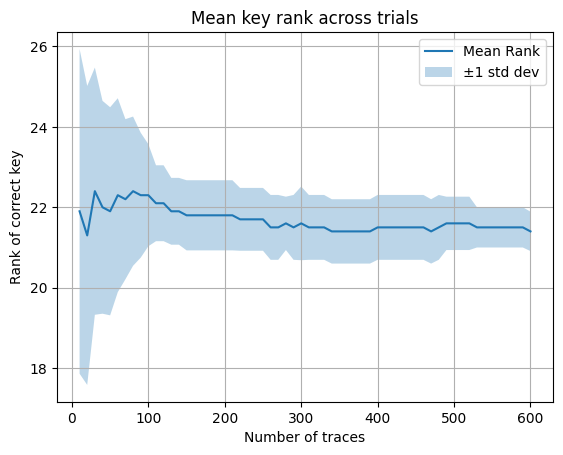

In [ ]:
steps, ranks = run_rank_trials(
        predictions,
        metadata_for_ranking,
        n_traces_per_trial=min(1000, val_size),
        n_trials=10,
        target_byte=3
    )

print("Plotting mean rank...")
plot_mean_rank(steps, ranks)

In [ ]:
######################################

In [ ]:
TARGET_BYTE = 13
WINDOW_TO_USE = 0
profiling_file = "/content/drive/MyDrive/mbedtls_synthetic_traces/RPA_traces/profiling_windows/byte_13.h5"
BATCH_SIZE = 128
EPOCHS = 50
VALIDATION_SPLIT = 0.2

In [ ]:
profiling_data_loader = SyntheticDataLoader(profiling_file)

In [ ]:
ds_train, ds_full_val, input_dim, train_size, val_size = profiling_data_loader.create_dataset(
        window_index=WINDOW_TO_USE,
        batch_size=BATCH_SIZE,
        val_split=VALIDATION_SPLIT
    )

Dataset created from 'byte_13.h5':
  - Total samples: 3001
  - Training samples: 2401
  - Validation samples: 600


In [ ]:
checkpoint_path = f"/content/drive/MyDrive/mbedtls_synthetic_traces/CNN_CBAM_byte{TARGET_BYTE}.keras"
model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
ds_val_for_fit = ds_full_val.map(lambda trace, label, pt, key: (trace, label))
print("\n--- Starting Model Training ---")
history = new_model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val_for_fit,
    steps_per_epoch=steps_per_epoch,
    callbacks=[model_checkpoint, early_stopping]
)

print("\n--- Training Finished ---")


--- Starting Model Training ---
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0079 - loss: 9.4409
Epoch 1: val_accuracy improved from -inf to 0.02167, saving model to /content/drive/MyDrive/mbedtls_synthetic_traces/CNN_CBAM_byte13.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 555ms/step - accuracy: 0.0081 - loss: 9.2667 - val_accuracy: 0.0217 - val_loss: 4.4308
Epoch 2/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0000e+00 - loss: 4.3962
Epoch 2: val_accuracy improved from 0.02167 to 0.03500, saving model to /content/drive/MyDrive/mbedtls_synthetic_traces/CNN_CBAM_byte13.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 637ms/step - accuracy: 0.0000e+00 - loss: 4.3962 - val_accuracy: 0.0350 - val_loss: 4.4696
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0272 - loss: 4.2208
Epoch 3: val_accuracy improved from 0.03500 to 0.07000, saving model to /content/drive/MyDrive/mbedtls_synthetic_traces/CNN_CBAM_byte13.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 567ms/step - a

In [ ]:
ds_val_for_predict = ds_full_val.map(lambda trace, label, pt, key: trace)
predictions = new_model.predict(ds_val_for_predict)

metadata_for_ranking = []
# Iterate through the original, complete validation dataset
# Create the full metadata structures rank eval functions expect
for _, _, pt, key in ds_full_val.unbatch():
    full_key = np.zeros(16, dtype=np.uint8)
    full_key[TARGET_BYTE] = key.numpy()
    full_pt = np.zeros(16, dtype=np.uint8)
    full_pt[TARGET_BYTE] = pt.numpy()
    metadata_for_ranking.append({'plaintext': full_pt, 'key': full_key})

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


Trials: 100%|██████████| 10/10 [01:35<00:00,  9.54s/it]

Plotting mean rank...


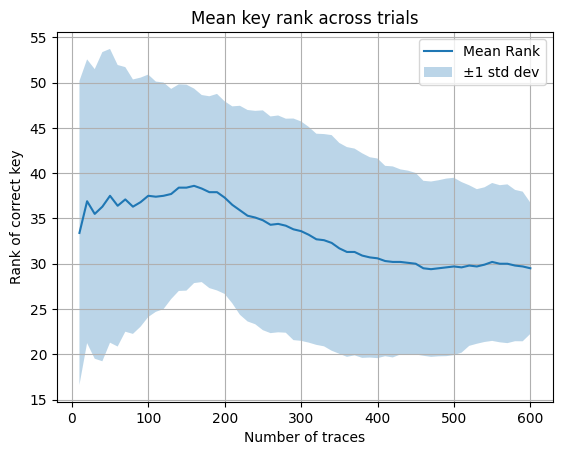

In [ ]:
steps, ranks = run_rank_trials(
        predictions,
        metadata_for_ranking,
        n_traces_per_trial=min(1000, val_size),
        n_trials=10,
        target_byte=TARGET_BYTE
    )

print("Plotting mean rank...")
plot_mean_rank(steps, ranks)

In [ ]:
TARGET_BYTE = 13
WINDOW_TO_USE = 0
attack_file = "/content/drive/MyDrive/mbedtls_synthetic_traces/RPA_traces/attack_windows/byte_13.h5"
BATCH_SIZE = 128
EPOCHS = 50
VALIDATION_SPLIT = 1.0

In [ ]:
attack_data_loader = SyntheticDataLoader(attack_file)

In [ ]:
ds_eval, ds_full_val, input_dim, train_size, val_size = attack_data_loader.create_dataset(
        window_index=WINDOW_TO_USE,
        batch_size=BATCH_SIZE,
        val_split=VALIDATION_SPLIT
    )

Dataset created from 'byte_13.h5':
  - Total samples: 601
  - Training samples: 0
  - Validation samples: 601


In [ ]:
model_checkpoint_file = f"/content/drive/MyDrive/mbedtls_synthetic_traces/CNN_CBAM_byte{TARGET_BYTE}.keras"

class ChannelwisePool(tf.keras.layers.Layer):
    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        return tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], 2)

loaded_model = tf.keras.models.load_model(
    model_checkpoint_file,
    custom_objects={'ChannelwisePool': ChannelwisePool}
)

In [ ]:
ds_eval_predict = ds_full_val.map(lambda trace, label, pt, key: trace)
predictions = loaded_model.predict(ds_eval_predict)

metadata_for_ranking = []
# Iterate through the original, complete validation dataset
# Create the full metadata structures rank eval functions expect
for _, _, pt, key in ds_full_val.unbatch():
    full_key = np.zeros(16, dtype=np.uint8)
    full_key[TARGET_BYTE] = key.numpy()
    full_pt = np.zeros(16, dtype=np.uint8)
    full_pt[TARGET_BYTE] = pt.numpy()
    metadata_for_ranking.append({'plaintext': full_pt, 'key': full_key})

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Trials: 100%|██████████| 10/10 [01:39<00:00, 10.00s/it]

Plotting mean rank...


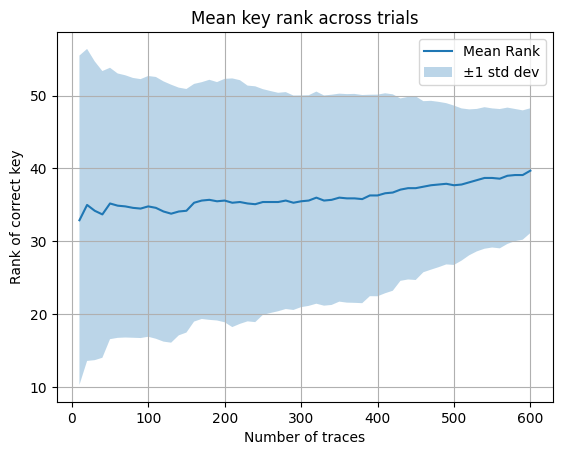

In [ ]:
steps, ranks = run_rank_trials(
        predictions,
        metadata_for_ranking,
        n_traces_per_trial=min(1000, val_size),
        n_trials=10,
        target_byte=TARGET_BYTE
    )

print("Plotting mean rank...")
plot_mean_rank(steps, ranks)

### v2

In [ ]:
TARGET_BYTE = 13
WINDOW_TO_USE = 0
profiling_file = "/content/drive/MyDrive/mbedtls_synthetic_traces/RPA_traces/v2_profiling_windows/byte_13.h5"
BATCH_SIZE = 128
EPOCHS = 50
VALIDATION_SPLIT = 0.2

In [ ]:
target_byte = 3
INPUT_DIM=701

In [ ]:
tuner = CleanMemoryTuner(
    hypermodel=lambda hp: vgg_cbam_synthetic_builder(
        hp,
        model_fun=vgg_cnn_cbam,
        input_dim=INPUT_DIM
    ),
    objective="val_accuracy",
    directory=TUNER_DIRECTORY,
    project_name=f"tuning_byte_{target_byte}",
    overwrite=False
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

print(f"Best trial ID: {best_trial.trial_id}")
print(f"Score: {best_trial.score}")

print("\nBuilding model architecture...")
model_to_load_into = tuner.hypermodel.build(best_hps)

# 4. Find the path to the saved weights from the best trial
trial_path = os.path.join(tuner.project_dir, best_trial.trial_id)
checkpoint_dir = os.path.join(trial_path, 'checkpoints')
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

print(f"Found best checkpoint at: {latest_checkpoint}")

# 5. Manually load the saved weights into your correctly-built model
print("\nLoading weights from checkpoint...")
model_to_load_into.load_weights(latest_checkpoint)

print("\nModel successfully loaded! ✅")
model_to_load_into.summary()

# Your fully trained model is now in the 'model_to_load_into' variable

Reloading Tuner from /content/drive/MyDrive/mbedtls_synthetic_traces/CBAM/hypertuning/tuning_byte_3/tuner0.json
Best trial ID: 07
Score: 0.9271000027656555

Building model architecture...


NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 350, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_15>',)
  • kwargs={'mask': 'None'}

In [ ]:
profiling_data_loader = SyntheticDataLoader(profiling_file)

In [ ]:
ds_train, ds_full_val, input_dim, train_size, val_size = profiling_data_loader.create_dataset(
        window_index=WINDOW_TO_USE,
        batch_size=BATCH_SIZE,
        val_split=VALIDATION_SPLIT
    )

Dataset created from 'byte_13.h5':
  - Total samples: 3001
  - Training samples: 2401
  - Validation samples: 600


In [ ]:
checkpoint_path = f"/content/drive/MyDrive/mbedtls_synthetic_traces/v2_CNN_CBAM_byte{TARGET_BYTE}.keras"
model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
ds_val_for_fit = ds_full_val.map(lambda trace, label, pt, key: (trace, label))
print("\n--- Starting Model Training ---")
history = model_to_load_into.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val_for_fit,
    steps_per_epoch=steps_per_epoch,
    callbacks=[model_checkpoint, early_stopping]
)

print("\n--- Training Finished ---")


--- Starting Model Training ---


NameError: name 'model_to_load_into' is not defined

In [ ]:
ds_eval_predict = ds_full_val.map(lambda trace, label, pt, key: trace)
predictions = model_to_load_into.predict(ds_eval_predict)

metadata_for_ranking = []
# Iterate through the original, complete validation dataset
# Create the full metadata structures rank eval functions expect
for _, _, pt, key in ds_full_val.unbatch():
    full_key = np.zeros(16, dtype=np.uint8)
    full_key[TARGET_BYTE] = key.numpy()
    full_pt = np.zeros(16, dtype=np.uint8)
    full_pt[TARGET_BYTE] = pt.numpy()
    metadata_for_ranking.append({'plaintext': full_pt, 'key': full_key})

In [ ]:
H5_FILE_PATH = '/content/drive/MyDrive/mbedtls_synthetic_traces/RPA_traces/v2_profiling_windows/byte_13.h5'

with h5py.File(H5_FILE_PATH, 'r') as hf:
    print(f"--- Inspecting File: {H5_FILE_PATH} ---")

    # 1. Check if the 'windows' dataset exists.
    # Your loader is trying to read hf['windows'].
    print("\nTop-level keys in file:", list(hf.keys()))
    if 'metadata' in hf:
        print("Keys in 'metadata':", list(hf['metadata'].keys()))

    # 2. Check the shape of the 'windows' dataset.
    if 'windows' in hf:
        windows_dset = hf['windows']
        print(f"\nShape of 'windows' dataset: {windows_dset.shape}")
        print(f"Data type of 'windows' dataset: {windows_dset.dtype}")

        # 3. Check the shape of a single trace slice.
        # This is what your generator is trying to do.
        try:
            # Let's check the first trace at window_index=0
            single_trace_slice = windows_dset[0, 0, :]
            print(f"\nShape of a single trace slice [0, 0, :]: {single_trace_slice.shape}")
        except IndexError:
            print("\nCould not slice 'windows' with [0, 0, :]. It might not be a 3D array.")
        except Exception as e:
            print(f"\nAn error occurred while slicing: {e}")

    else:
        print("\nERROR: The dataset 'windows' was not found in the file!")

--- Inspecting File: /content/drive/MyDrive/mbedtls_synthetic_traces/RPA_traces/v2_profiling_windows/byte_13.h5 ---

Top-level keys in file: ['labels', 'metadata', 'windows']
Keys in 'metadata': ['annotations_idcs', 'annotations_names', 'hashes', 'key', 'masks_rin', 'masks_rout', 'peak_positions', 'plaintexts', 'prands']

Shape of 'windows' dataset: (3001, 5, 701)
Data type of 'windows' dataset: float64

Shape of a single trace slice [0, 0, :]: (701,)
